In [ ]:
import pandas as pd
from transformers import pipeline
from pgmpy.estimators import HillClimbSearch, AICScore
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.readwrite import BIFWriter, XMLBIFWriter, NETWriter, UAIWriter
from pgmpy.inference import VariableElimination

In [4]:
# import tsv file into dataframe
df_train = pd.read_csv('initial_data_tsv/train.tsv', sep='\t', header=None)
df_test = pd.read_csv('initial_data_tsv/test.tsv', sep='\t', header=None)
df_valid = pd.read_csv('initial_data_tsv/valid.tsv', sep='\t', header=None)

# merge train, yest and valid dataframes
df = pd.concat([df_train, df_test, df_valid])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,3419.json,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a press conference
1280,12548.json,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a speech on the economy
1281,401.json,true,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,NaN,"Washington, D.C.",none,0.0,1.0,0.0,2.0,0.0,a television ad
1282,1055.json,false,A new poll shows 62 percent support the presid...,health-care,americans-united-change,NaN,NaN,none,1.0,4.0,4.0,1.0,0.0,an Internet ad.


In [5]:
liar_dataset_columns = [
    'ID', 
    'Label', 
    'Statement', 
    'Subject', 
    'Speaker', 
    'Speaker\'s Job Title', 
    'State Info', 
    'Party Affiliation', 
    'Barely True Counts', 
    'False Counts', 
    'Half True Counts', 
    'Mostly True Counts', 
    'Pants on Fire Counts', 
    'Context'
]

df01 = df.copy()
df01.columns = liar_dataset_columns
df01

,ID,Label,Statement,Subject,Speaker,Speaker's Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,3419.json,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a press conference
1280,12548.json,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a speech on the economy
1281,401.json,true,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,NaN,"Washington, D.C.",none,0.0,1.0,0.0,2.0,0.0,a television ad
1282,1055.json,false,A new poll shows 62 percent support the presid...,health-care,americans-united-change,NaN,NaN,none,1.0,4.0,4.0,1.0,0.0,an Internet ad.


In [6]:
def calculate_credibility_score(df, w1=2, w2=1, w3=0.5, w4=-2, w5=-3):
    # Calculate total statements count
    df['Total Statements'] = df['Barely True Counts'] + df['False Counts'] + df['Half True Counts'] + df['Mostly True Counts'] + df['Pants on Fire Counts']
    
    # Calculate weighted score
    df['Credibility Score'] = ((df['Mostly True Counts'] * w1) +
                               (df['Half True Counts'] * w2) +
                               (df['Barely True Counts'] * w3) +
                               (df['False Counts'] * w4) +
                               (df['Pants on Fire Counts'] * w5)) / df['Total Statements']
    
    # Drop the original counts columns
    df = df.drop(columns=['ID', 'State Info', 'Barely True Counts', 'False Counts', 'Half True Counts', 'Mostly True Counts', 'Pants on Fire Counts', 'Total Statements', 'Speaker'])
    
    return df

df01 = calculate_credibility_score(df01)

In [7]:
# drop nan values
df02 = df01.copy()
df02 = df02.dropna()
df02

,Label,Statement,Subject,Speaker's Job Title,Party Affiliation,Context,Credibility Score
0,false,Says the Annies List political group supports ...,abortion,State representative,republican,a mailer,-2.000000
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",State delegate,democrat,a floor speech.,1.500000
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,President,democrat,Denver,0.744186
5,true,The Chicago Bears have had more starting quart...,education,Wisconsin Assembly speaker,republican,a an online opinion-piece,0.272727
7,half-true,I'm the only person on this stage who has work...,ethics,President,democrat,"a Democratic debate in Philadelphia, Pa.",0.744186
...,...,...,...,...,...,...,...
1276,barely-true,Says U.S. Rep. Charles Bass wants to privatize...,social-security,Attorney,democrat,"an ad, “Janice,” released September 6, 2012",0.333333
1278,pants-fire,"In the past two years, Democrats have spent mo...","federal-budget,history",House Majority Leader,republican,an interview on Comedy Central's Daily Show wi...,-0.277778
1279,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",President,democrat,a press conference,0.744186
1280,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,Presidential candidate,democrat,a speech on the economy,0.733032


In [8]:
# distinct values in Party Affiliation column
df02['Party Affiliation'].unique()

array(['republican', 'democrat', 'independent', 'columnist', 'none',
       'activist', 'talk-show-host', 'libertarian', 'newsmaker',
       'organization', 'journalist', 'labor-leader', 'state-official',
       'education-official', 'business-leader', 'tea-party-member',
       'green', 'liberal-party-canada', 'Moderate',
       'democratic-farmer-labor', 'ocean-state-tea-party-action',
       'constitution-party', 'county-commissioner'], dtype=object)

In [9]:
def categorize_party(affiliation):
    if affiliation in ['republican', 'tea-party-member', 'libertarian']:
        return 'Republican'
    elif affiliation in ['democrat', 'democratic-farmer-labor', 'liberal-party-canada', 'green']:
        return 'Democrat'
    elif affiliation in ['independent', 'Moderate']:
        return 'Independent'
    elif affiliation in ['columnist', 'journalist']:
        return 'Media'
    else:
        return 'Other'

# Assume 'df' is your DataFrame and 'Party Affiliation' is the column of interest
df02['Party Affiliation'] = df02['Party Affiliation'].apply(categorize_party)


In [10]:
df02

,Label,Statement,Subject,Speaker's Job Title,Party Affiliation,Context,Credibility Score
0,false,Says the Annies List political group supports ...,abortion,State representative,Republican,a mailer,-2.000000
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",State delegate,Democrat,a floor speech.,1.500000
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,President,Democrat,Denver,0.744186
5,true,The Chicago Bears have had more starting quart...,education,Wisconsin Assembly speaker,Republican,a an online opinion-piece,0.272727
7,half-true,I'm the only person on this stage who has work...,ethics,President,Democrat,"a Democratic debate in Philadelphia, Pa.",0.744186
...,...,...,...,...,...,...,...
1276,barely-true,Says U.S. Rep. Charles Bass wants to privatize...,social-security,Attorney,Democrat,"an ad, “Janice,” released September 6, 2012",0.333333
1278,pants-fire,"In the past two years, Democrats have spent mo...","federal-budget,history",House Majority Leader,Republican,an interview on Comedy Central's Daily Show wi...,-0.277778
1279,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",President,Democrat,a press conference,0.744186
1280,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,Presidential candidate,Democrat,a speech on the economy,0.733032


In [11]:
def categorize_job_title(title):
    title = title.lower().strip()
    if any(word in title for word in ['president', 'governor', 'senator', 'representative', 'mayor', 'congress', 'delegate', 'speaker', 'secretary', 'commissioner', 'auditor', 'lieutenant governor', 'treasurer', 'assembly']):
        return 'Government Officials'
    elif any(word in title for word in ['host', 'columnist', 'commentator', 'journalist', 'editor', 'media', 'broadcaster', 'anchor']):
        return 'Media Professionals'
    elif any(word in title for word in ['ceo', 'businessman', 'executive', 'industry', 'director', 'entrepreneur', 'manager']):
        return 'Business & Industry Leaders'
    elif any(word in title for word in ['attorney', 'lawyer', 'advocacy', 'counsel', 'legal', 'solicitor']):
        return 'Legal & Advocacy'
    elif any(word in title for word in ['professor', 'educator', 'teacher', 'nonprofit', 'philanthropist', 'chairman', 'academic']):
        return 'Education & Non-Profit'
    else:
        return 'Others'

# Applying the function to the column in your DataFrame
df02['Categorized Job Title'] = df02['Speaker\'s Job Title'].apply(categorize_job_title)

In [12]:
# drop the column 'Speaker\'s Job Title'
df03 = df02.copy()
df03 = df03.drop(columns=['Speaker\'s Job Title'])
df03

,Label,Statement,Subject,Party Affiliation,Context,Credibility Score,Categorized Job Title
0,false,Says the Annies List political group supports ...,abortion,Republican,a mailer,-2.000000,Government Officials
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Democrat,a floor speech.,1.500000,Government Officials
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Democrat,Denver,0.744186,Government Officials
5,true,The Chicago Bears have had more starting quart...,education,Republican,a an online opinion-piece,0.272727,Government Officials
7,half-true,I'm the only person on this stage who has work...,ethics,Democrat,"a Democratic debate in Philadelphia, Pa.",0.744186,Government Officials
...,...,...,...,...,...,...,...
1276,barely-true,Says U.S. Rep. Charles Bass wants to privatize...,social-security,Democrat,"an ad, “Janice,” released September 6, 2012",0.333333,Legal & Advocacy
1278,pants-fire,"In the past two years, Democrats have spent mo...","federal-budget,history",Republican,an interview on Comedy Central's Daily Show wi...,-0.277778,Others
1279,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",Democrat,a press conference,0.744186,Government Officials
1280,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,Democrat,a speech on the economy,0.733032,Government Officials


In [13]:
def categorize_subject(subject):
    politics_gov = ['elections', 'federal-budget', 'congress', 'state-budget', 'city-government', 'state-government']
    economy_finance = ['economy', 'jobs', 'taxes', 'financial-regulation', 'market-regulation', 'bankruptcy']
    social_issues = ['abortion', 'crime', 'civil-rights', 'diversity', 'social-security', 'marriage', 'ethics', 'poverty', 'immigration']
    healthcare = ['health-care', 'public-health', 'medicare', 'medicaid', 'ebola', 'drugs']
    foreign_policy_security = ['foreign-policy', 'terrorism', 'homeland-security', 'military', 'nuclear', 'afghanistan', 'iraq', 'israel']
    environment_energy = ['climate-change', 'energy', 'environment', 'oil-spill', 'gas-prices', 'water']
    law_ethics = ['ethics', 'legal-issues', 'supreme-court', 'criminal-justice']
    
    subject = subject.lower().strip()
    # Splitting the subject string by commas and checking for keywords
    subject_keywords = subject.split(',')
    
    for keyword in subject_keywords:
        if keyword in politics_gov:
            return 'Politics and Government'
        elif keyword in economy_finance:
            return 'Economy and Finance'
        elif keyword in social_issues:
            return 'Social Issues'
        elif keyword in healthcare:
            return 'Healthcare'
        elif keyword in foreign_policy_security:
            return 'Foreign Policy and Security'
        elif keyword in environment_energy:
            return 'Environment and Energy'
        elif keyword in law_ethics:
            return 'Law and Ethics'
    return 'Other'

# Assuming 'subjects' is a list of subject strings from your dataset
df03['Categorized Subject'] = df03['Subject'].apply(categorize_subject)

In [14]:
# drop the column 'Subject'
df04 = df03.copy()
df04 = df04.drop(columns=['Subject'])
df04

,Label,Statement,Party Affiliation,Context,Credibility Score,Categorized Job Title,Categorized Subject
0,false,Says the Annies List political group supports ...,Republican,a mailer,-2.000000,Government Officials,Social Issues
1,half-true,When did the decline of coal start? It started...,Democrat,a floor speech.,1.500000,Government Officials,Environment and Energy
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",Democrat,Denver,0.744186,Government Officials,Foreign Policy and Security
5,true,The Chicago Bears have had more starting quart...,Republican,a an online opinion-piece,0.272727,Government Officials,Other
7,half-true,I'm the only person on this stage who has work...,Democrat,"a Democratic debate in Philadelphia, Pa.",0.744186,Government Officials,Social Issues
...,...,...,...,...,...,...,...
1276,barely-true,Says U.S. Rep. Charles Bass wants to privatize...,Democrat,"an ad, “Janice,” released September 6, 2012",0.333333,Legal & Advocacy,Social Issues
1278,pants-fire,"In the past two years, Democrats have spent mo...",Republican,an interview on Comedy Central's Daily Show wi...,-0.277778,Others,Politics and Government
1279,half-true,"For the first time in more than a decade, impo...",Democrat,a press conference,0.744186,Government Officials,Environment and Energy
1280,mostly-true,Says Donald Trump has bankrupted his companies...,Democrat,a speech on the economy,0.733032,Government Officials,Other


In [15]:
def categorize_context(context):
    broadcast_media = ['interview', 'debate', 'TV', 'radio', 'CNN', 'MSNBC', 'Fox News', 'ABC', 'CBS', 'NBC', 'ESPN', 'YouTube', 'town hall']
    print_online_publications = ['newspaper', 'online', 'blog', 'editorial', 'column', 'article', 'news story', 'op-ed']
    public_speaking = ['speech', 'conference', 'rally', 'press conference', 'public', 'remarks', 'address', 'convention', 'forum', 'meeting', 'panel', 'symposium']
    social_media_online = ['social media', 'Facebook', 'tweet', 'Instagram', 'online', 'website', 'web', 'YouTube']
    legislative_official = ['hearing', 'Senate', 'House', 'legislative', 'committee', 'floor', 'session', 'official', 'council', 'chamber']
    personal_campaign = ['mailer', 'campaign', 'email', 'newsletter', 'fundraising', 'letter', 'ad', 'advertisement', 'statement']

    context = context.lower().strip()
    
    if any(keyword in context for keyword in broadcast_media):
        return 'Broadcast Media'
    elif any(keyword in context for keyword in print_online_publications):
        return 'Print and Online Publications'
    elif any(keyword in context for keyword in public_speaking):
        return 'Public Speaking'
    elif any(keyword in context for keyword in social_media_online):
        return 'Social Media and Online Platforms'
    elif any(keyword in context for keyword in legislative_official):
        return 'Legislative and Official Proceedings'
    elif any(keyword in context for keyword in personal_campaign):
        return 'Personal and Campaign Communications'
    else:
        return 'Other'

# Assuming 'contexts' is a list of context strings from your dataset
df04['Categorized Context'] = df04['Context'].apply(categorize_context)

In [16]:
# drop the column 'Subject'
df05 = df04.copy()
df05 = df05.drop(columns=['Context'])
df05

,Label,Statement,Party Affiliation,Credibility Score,Categorized Job Title,Categorized Subject,Categorized Context
0,false,Says the Annies List political group supports ...,Republican,-2.000000,Government Officials,Social Issues,Personal and Campaign Communications
1,half-true,When did the decline of coal start? It started...,Democrat,1.500000,Government Officials,Environment and Energy,Public Speaking
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",Democrat,0.744186,Government Officials,Foreign Policy and Security,Other
5,true,The Chicago Bears have had more starting quart...,Republican,0.272727,Government Officials,Other,Print and Online Publications
7,half-true,I'm the only person on this stage who has work...,Democrat,0.744186,Government Officials,Social Issues,Broadcast Media
...,...,...,...,...,...,...,...
1276,barely-true,Says U.S. Rep. Charles Bass wants to privatize...,Democrat,0.333333,Legal & Advocacy,Social Issues,Personal and Campaign Communications
1278,pants-fire,"In the past two years, Democrats have spent mo...",Republican,-0.277778,Others,Politics and Government,Broadcast Media
1279,half-true,"For the first time in more than a decade, impo...",Democrat,0.744186,Government Officials,Environment and Energy,Public Speaking
1280,mostly-true,Says Donald Trump has bankrupted his companies...,Democrat,0.733032,Government Officials,Other,Public Speaking


In [17]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")


def get_sentiment(text):
    return sentiment_pipeline(text)[0]['label']

df05['Sentiment'] = df05['Statement'].apply(get_sentiment)

In [20]:
df05

,Label,Statement,Party Affiliation,Credibility Score,Categorized Job Title,Categorized Subject,Categorized Context,Sentiment
0,false,Says the Annies List political group supports ...,Republican,-2.000000,Government Officials,Social Issues,Personal and Campaign Communications,NEGATIVE
1,half-true,When did the decline of coal start? It started...,Democrat,1.500000,Government Officials,Environment and Energy,Public Speaking,NEGATIVE
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",Democrat,0.744186,Government Officials,Foreign Policy and Security,Other,POSITIVE
5,true,The Chicago Bears have had more starting quart...,Republican,0.272727,Government Officials,Other,Print and Online Publications,NEGATIVE
7,half-true,I'm the only person on this stage who has work...,Democrat,0.744186,Government Officials,Social Issues,Broadcast Media,NEGATIVE
...,...,...,...,...,...,...,...,...
1276,barely-true,Says U.S. Rep. Charles Bass wants to privatize...,Democrat,0.333333,Legal & Advocacy,Social Issues,Personal and Campaign Communications,NEGATIVE
1278,pants-fire,"In the past two years, Democrats have spent mo...",Republican,-0.277778,Others,Politics and Government,Broadcast Media,NEGATIVE
1279,half-true,"For the first time in more than a decade, impo...",Democrat,0.744186,Government Officials,Environment and Energy,Public Speaking,NEGATIVE
1280,mostly-true,Says Donald Trump has bankrupted his companies...,Democrat,0.733032,Government Officials,Other,Public Speaking,NEGATIVE


In [21]:
# save as csv file
df06 = df05.copy()
df06.to_csv('final_data/liar_dataset_sentiment_score.csv', index=False)

In [22]:
subjectivity_pipeline = pipeline("text-classification", model="GroNLP/mdebertav3-subjectivity-english")

df06['Subjectivity'] = df06['Statement'].apply(lambda x: subjectivity_pipeline(x)[0]['label'])

In [23]:
df06

,Label,Statement,Party Affiliation,Credibility Score,Categorized Job Title,Categorized Subject,Categorized Context,Sentiment,Subjectivity
0,false,Says the Annies List political group supports ...,Republican,-2.000000,Government Officials,Social Issues,Personal and Campaign Communications,NEGATIVE,LABEL_0
1,half-true,When did the decline of coal start? It started...,Democrat,1.500000,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,LABEL_0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",Democrat,0.744186,Government Officials,Foreign Policy and Security,Other,POSITIVE,LABEL_0
5,true,The Chicago Bears have had more starting quart...,Republican,0.272727,Government Officials,Other,Print and Online Publications,NEGATIVE,LABEL_0
7,half-true,I'm the only person on this stage who has work...,Democrat,0.744186,Government Officials,Social Issues,Broadcast Media,NEGATIVE,LABEL_1
...,...,...,...,...,...,...,...,...,...
1276,barely-true,Says U.S. Rep. Charles Bass wants to privatize...,Democrat,0.333333,Legal & Advocacy,Social Issues,Personal and Campaign Communications,NEGATIVE,LABEL_0
1278,pants-fire,"In the past two years, Democrats have spent mo...",Republican,-0.277778,Others,Politics and Government,Broadcast Media,NEGATIVE,LABEL_0
1279,half-true,"For the first time in more than a decade, impo...",Democrat,0.744186,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,LABEL_0
1280,mostly-true,Says Donald Trump has bankrupted his companies...,Democrat,0.733032,Government Officials,Other,Public Speaking,NEGATIVE,LABEL_0


In [24]:
# in column Subjectivity, replace LABEL_0 with OBJECTIVE and Label_1 with SUBJECTIVE
df07 = df06.copy()
df07['Subjectivity'] = df07['Subjectivity'].replace('LABEL_0', 'OBJECTIVE')
df07['Subjectivity'] = df07['Subjectivity'].replace('LABEL_1', 'SUBJECTIVE')
df07

,Label,Statement,Party Affiliation,Credibility Score,Categorized Job Title,Categorized Subject,Categorized Context,Sentiment,Subjectivity
0,false,Says the Annies List political group supports ...,Republican,-2.000000,Government Officials,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1,half-true,When did the decline of coal start? It started...,Democrat,1.500000,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",Democrat,0.744186,Government Officials,Foreign Policy and Security,Other,POSITIVE,OBJECTIVE
5,true,The Chicago Bears have had more starting quart...,Republican,0.272727,Government Officials,Other,Print and Online Publications,NEGATIVE,OBJECTIVE
7,half-true,I'm the only person on this stage who has work...,Democrat,0.744186,Government Officials,Social Issues,Broadcast Media,NEGATIVE,SUBJECTIVE
...,...,...,...,...,...,...,...,...,...
1276,barely-true,Says U.S. Rep. Charles Bass wants to privatize...,Democrat,0.333333,Legal & Advocacy,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1278,pants-fire,"In the past two years, Democrats have spent mo...",Republican,-0.277778,Others,Politics and Government,Broadcast Media,NEGATIVE,OBJECTIVE
1279,half-true,"For the first time in more than a decade, impo...",Democrat,0.744186,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
1280,mostly-true,Says Donald Trump has bankrupted his companies...,Democrat,0.733032,Government Officials,Other,Public Speaking,NEGATIVE,OBJECTIVE


In [25]:
# save as csv file
df08 = df07.copy()
df08.to_csv('final_data/liar_dataset_complete.csv', index=False)

In [26]:
df08

,Label,Statement,Party Affiliation,Credibility Score,Categorized Job Title,Categorized Subject,Categorized Context,Sentiment,Subjectivity
0,false,Says the Annies List political group supports ...,Republican,-2.000000,Government Officials,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1,half-true,When did the decline of coal start? It started...,Democrat,1.500000,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",Democrat,0.744186,Government Officials,Foreign Policy and Security,Other,POSITIVE,OBJECTIVE
5,true,The Chicago Bears have had more starting quart...,Republican,0.272727,Government Officials,Other,Print and Online Publications,NEGATIVE,OBJECTIVE
7,half-true,I'm the only person on this stage who has work...,Democrat,0.744186,Government Officials,Social Issues,Broadcast Media,NEGATIVE,SUBJECTIVE
...,...,...,...,...,...,...,...,...,...
1276,barely-true,Says U.S. Rep. Charles Bass wants to privatize...,Democrat,0.333333,Legal & Advocacy,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1278,pants-fire,"In the past two years, Democrats have spent mo...",Republican,-0.277778,Others,Politics and Government,Broadcast Media,NEGATIVE,OBJECTIVE
1279,half-true,"For the first time in more than a decade, impo...",Democrat,0.744186,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
1280,mostly-true,Says Donald Trump has bankrupted his companies...,Democrat,0.733032,Government Officials,Other,Public Speaking,NEGATIVE,OBJECTIVE


In [27]:
# drop column Statements
df09 = df08.copy()
df09 = df09.drop(columns=['Statement'])

In [28]:
df09

,Label,Party Affiliation,Credibility Score,Categorized Job Title,Categorized Subject,Categorized Context,Sentiment,Subjectivity
0,false,Republican,-2.000000,Government Officials,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1,half-true,Democrat,1.500000,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
2,mostly-true,Democrat,0.744186,Government Officials,Foreign Policy and Security,Other,POSITIVE,OBJECTIVE
5,true,Republican,0.272727,Government Officials,Other,Print and Online Publications,NEGATIVE,OBJECTIVE
7,half-true,Democrat,0.744186,Government Officials,Social Issues,Broadcast Media,NEGATIVE,SUBJECTIVE
...,...,...,...,...,...,...,...,...
1276,barely-true,Democrat,0.333333,Legal & Advocacy,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1278,pants-fire,Republican,-0.277778,Others,Politics and Government,Broadcast Media,NEGATIVE,OBJECTIVE
1279,half-true,Democrat,0.744186,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
1280,mostly-true,Democrat,0.733032,Government Officials,Other,Public Speaking,NEGATIVE,OBJECTIVE


In [32]:
# rename the columns Credibility Score, Categorized Job Title, Categorized Subject, Categorized Context to Past_Credibility, Job_Title, Subject, Context respectively
df10 = df09.copy()
df10.columns = ['Credibility_Label', 'Party_Affiliation', 'Past_Credibility_Score', 'Job_Title', 'Subject', 'Context', 'Sentiment', 'Subjectivity']
df10

,Credibility_Label,Party_Affiliation,Past_Credibility_Score,Job_Title,Subject,Context,Sentiment,Subjectivity
0,false,Republican,-2.000000,Government Officials,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1,half-true,Democrat,1.500000,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
2,mostly-true,Democrat,0.744186,Government Officials,Foreign Policy and Security,Other,POSITIVE,OBJECTIVE
5,true,Republican,0.272727,Government Officials,Other,Print and Online Publications,NEGATIVE,OBJECTIVE
7,half-true,Democrat,0.744186,Government Officials,Social Issues,Broadcast Media,NEGATIVE,SUBJECTIVE
...,...,...,...,...,...,...,...,...
1276,barely-true,Democrat,0.333333,Legal & Advocacy,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1278,pants-fire,Republican,-0.277778,Others,Politics and Government,Broadcast Media,NEGATIVE,OBJECTIVE
1279,half-true,Democrat,0.744186,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
1280,mostly-true,Democrat,0.733032,Government Officials,Other,Public Speaking,NEGATIVE,OBJECTIVE


In [37]:
# save as csv file
df11 = df10.copy()
df11.to_csv('final_data/complete_df.csv', index=False)

In [38]:
def discretize_credibility(score):
    if score < -3:
        return 'below -3'
    elif -3 <= score < -1:
        return '-3 to -1'
    elif -1 <= score < 1:
        return '-1 to 1'
    elif 1 <= score < 3:
        return '1 to 3'
    else:
        return 'above 3'

df11['Past_Credibility_Score'] = df11['Past_Credibility_Score'].apply(discretize_credibility)

df11

,Credibility_Label,Party_Affiliation,Past_Credibility_Score,Job_Title,Subject,Context,Sentiment,Subjectivity
0,false,Republican,-3 to -1,Government Officials,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1,half-true,Democrat,1 to 3,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
2,mostly-true,Democrat,-1 to 1,Government Officials,Foreign Policy and Security,Other,POSITIVE,OBJECTIVE
5,true,Republican,-1 to 1,Government Officials,Other,Print and Online Publications,NEGATIVE,OBJECTIVE
7,half-true,Democrat,-1 to 1,Government Officials,Social Issues,Broadcast Media,NEGATIVE,SUBJECTIVE
...,...,...,...,...,...,...,...,...
1276,barely-true,Democrat,-1 to 1,Legal & Advocacy,Social Issues,Personal and Campaign Communications,NEGATIVE,OBJECTIVE
1278,pants-fire,Republican,-1 to 1,Others,Politics and Government,Broadcast Media,NEGATIVE,OBJECTIVE
1279,half-true,Democrat,-1 to 1,Government Officials,Environment and Energy,Public Speaking,NEGATIVE,OBJECTIVE
1280,mostly-true,Democrat,-1 to 1,Government Officials,Other,Public Speaking,NEGATIVE,OBJECTIVE


In [74]:
# Assuming df is your preprocessed DataFrame
hc = HillClimbSearch(df11)
aic = AICScore(df11)
best_model = hc.estimate(scoring_method=aic)
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Party_Affiliation', 'Past_Credibility_Score'), ('Party_Affiliation', 'Context'), ('Party_Affiliation', 'Credibility_Label'), ('Past_Credibility_Score', 'Credibility_Label'), ('Past_Credibility_Score', 'Subjectivity'), ('Job_Title', 'Party_Affiliation'), ('Job_Title', 'Past_Credibility_Score'), ('Job_Title', 'Context'), ('Subject', 'Job_Title'), ('Subject', 'Sentiment'), ('Context', 'Subjectivity'), ('Subjectivity', 'Sentiment')]


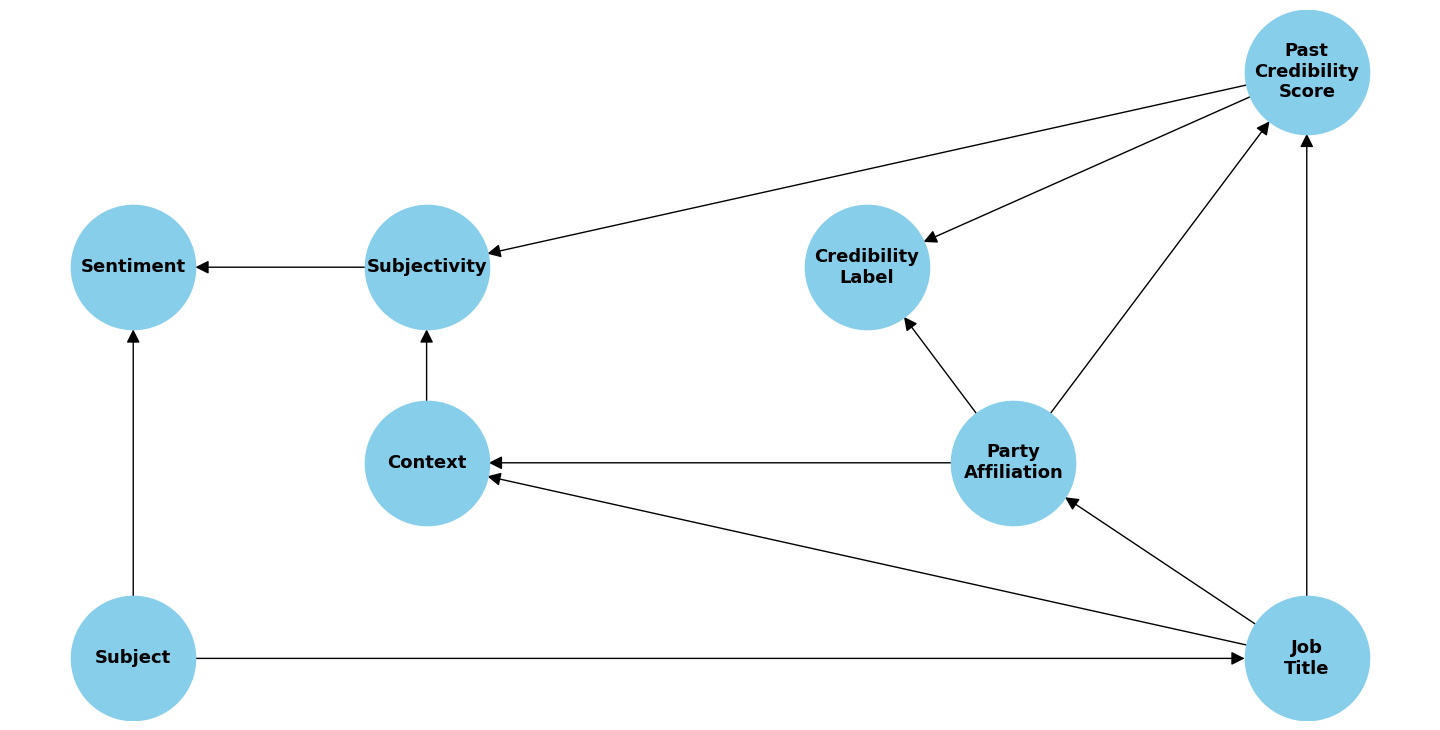

In [130]:
# Create a directed graph from the edges
G = nx.DiGraph()
G.add_edges_from([('Party\nAffiliation', 'Past\nCredibility\nScore'), ('Party\nAffiliation', 'Context'), ('Party\nAffiliation', 'Credibility\nLabel'), ('Past\nCredibility\nScore', 'Credibility\nLabel'), ('Past\nCredibility\nScore', 'Subjectivity'), ('Job\nTitle', 'Party\nAffiliation'), ('Job\nTitle', 'Past\nCredibility\nScore'), ('Job\nTitle', 'Context'), ('Subject', 'Job\nTitle'), ('Subject', 'Sentiment'), ('Context', 'Subjectivity'), ('Subjectivity', 'Sentiment')]
)

# Manually define positions
pos = {
    'Party\nAffiliation': (1, 1),
    'Past\nCredibility\nScore': (2, 1.2),
    'Context': (-1, 1),
    'Credibility\nLabel': (0.5, 1.1),
    'Job\nTitle': (2, 0.9),
    'Subject': (-2, 0.9),
    'Subjectivity': (-1,1.1),
    'Sentiment': (-2,1.1)
}

# Draw the graph
plt.figure(figsize=(14.2, 7.1))  # Set the size of the plot
nx.draw(G, pos, with_labels=True, node_size=8000, node_color='skyblue', font_size=13, font_weight='bold', arrowsize=20)

# Show the plot
plt.show()


In [135]:
# Parameter Learning

# Create a Bayesian Network with the structure learned from the data
bayesian_model = BayesianNetwork(best_model.edges())

# Learn the parameters of the model (i.e., the CPTs)
bayesian_model.fit(df11, estimator=MaximumLikelihoodEstimator)


In [137]:
writer = NETWriter(bayesian_model)

writer.write_net(filename='model_01.net')

In [141]:
# Inference

inference = VariableElimination(bayesian_model)

# Now you can query the network, for example, the probability distribution for 'Credibility_Label'
result = inference.query(variables=['Context'])
print(result)


+-----------------------------------------------+----------------+
| Context                                       |   phi(Context) |
+===============================================+================+
| Context(Broadcast Media)                      |         0.3079 |
+-----------------------------------------------+----------------+
| Context(Legislative and Official Proceedings) |         0.0182 |
+-----------------------------------------------+----------------+
| Context(Other)                                |         0.2046 |
+-----------------------------------------------+----------------+
| Context(Personal and Campaign Communications) |         0.1425 |
+-----------------------------------------------+----------------+
| Context(Print and Online Publications)        |         0.0559 |
+-----------------------------------------------+----------------+
| Context(Public Speaking)                      |         0.2204 |
+-----------------------------------------------+-------------